In [1]:
from datetime import datetime as dt
import numpy as np
import collections
import pandas as pd
import matplotlib.pyplot as plt

## Plot PDFs

In [135]:
def K_to_eps(K):
    return 2*np.log((K+1.) / K)

def eps_to_K(eps):
    return max(1, np.ceil(1./(np.exp(eps/2.) -1)))

def pdf_laplace(eps, g, x):
    b = g / eps
    return (1./(2*b))*np.exp(-1.*np.abs(x)/b)

def pdf_unif(K, g, x, batched=False):
    if x < 0:
        return 0
    if batched and x <= g*(K+1) and x >=g:
        return (1 / (g*K))
    if not batched and x <= g*(K+1):
        return 1/(g*(K+1))
    else:
        return 0

def pdf_staircase(eps, g, x, gamma=None):
    x = np.abs(x)
    if gamma is None:
        gamma = 1/(1+np.exp(eps/2.))
    # NOTE: drop factor of 2 in denom
    alpha = (1-np.exp(-1*eps)) / (g*(gamma + np.exp(-1*eps)*(1-gamma)))
    k = (np.floor((x - gamma*g) / g))
    return np.exp(-1*(k+1)*eps) * alpha

def pdf_exp(eps, g, x):
    l = eps / g
    return l*np.exp(-l*x)

def pdf_geometric(eps, g, x):
    k = np.floor(np.abs(x))
    p =  1. - np.exp(-1*eps/g)
    return p*(1-p)**k

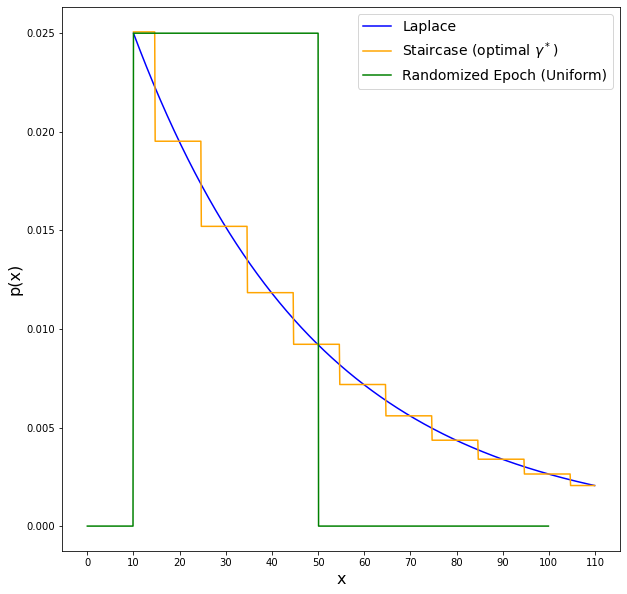

In [143]:
fig, ax = plt.subplots(figsize=(10,10))

batched=True
g = 10
eps = .5
K = eps_to_K(eps)
xs = np.arange(0, 100, 0.1)
# ax.plot(xs, [pdf_staircase(eps/2., g, x, gamma=0) for x in xs], label=r'staircase ($\gamma =0$)')

ax.plot(a + xs, [pdf_exp(eps/2., g, x) for x in xs], label='Laplace', color='blue')
ax.plot(a + xs, [pdf_staircase(eps/2., g, x) for x in xs], label='Staircase (optimal $\gamma^*$)', color='orange')
ax.plot(xs, [pdf_unif(K, g, x, batched) for x in xs], label='Randomized Epoch (Uniform)', color='green')
a = g if batched else 0

ax.legend(fontsize=14)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('p(x)', fontsize=16)
ax.set_xticks(np.arange(0, max(xs)+a+1, g))

plt.show()

In [11]:
def expected_delay_geom(g, eps):
    p = 1. - np.exp(-1*eps/(2*g))
    return g + ((1. - p) / p)

# gamma = OPT
def expected_delay_staircase(g, eps):
    # add 0.5 to give continuous uniform
    return  + g*(np.exp(eps/4.) / (np.exp(eps/2.) - 1)) + 1.5*g

def expected_delay_laplace(g, eps):
    return 2*g/eps + g

def expected_delay_unif(g, K):
    return g + ((K + 1) / 2.)*g

In [144]:
def plot_delays(g, K_max=10, eps_max=4., ax=None, batched=True):
    if ax == None:
        fig, ax = plt.subplots(figsize=(10,10))
    
    eps_range = np.arange(K_to_eps(K_max), eps_max + 0.1, 0.1)
    K_range = np.arange(1, K_max)
    K_range_plt = [max(eps_range)] + [2*np.log((K+1) / K) for K in np.arange(1,K_max)]
    
    expected_delays_lapl = [expected_delay_laplace(g, eps) / g for eps in eps_range]
    expected_delays_staircase = [expected_delay_staircase(g, eps) / g for eps in eps_range]
    expected_delays_unif = [0.5 + expected_delay_unif(g, K) / g for K in K_range]
    
    ax.plot(eps_range, expected_delays_lapl, label='Laplace DP Random Delay', color='blue')
    ax.plot(eps_range, expected_delays_staircase, label='Staircase DP Random Delay', color='orange')
    ax.step(K_range_plt, [expected_delays_unif[0]]+expected_delays_unif,
                where='pre', label='Randomized Epoch', color='green') # 'ro-'
            
    ax.set_xlabel(r'$\epsilon$', fontsize=14)
    ax.set_ylabel(r'Expected Delay of Batched Comments (as a multiple of $g$)', fontsize=14)
    ax.set_yticks(np.arange(1,12,1))
    
    ax.legend(fontsize=14)

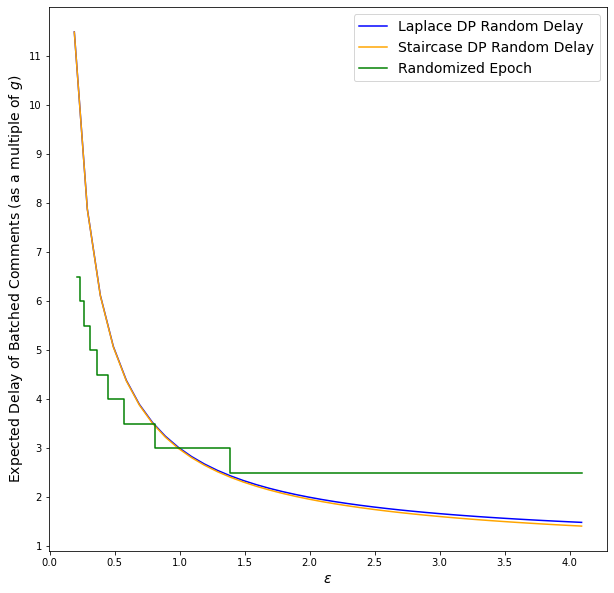

In [145]:
plot_delays(10)

In [146]:
def plot_lapl_staircase_ratio(g, eps_max=10., ax=None):
    if ax == None:
        fig, ax = plt.subplots(figsize=(10,10))
    
    eps_range = np.arange(0.001, eps_max + 0.1, 0.1)
    
    expected_delays_lapl = [expected_delay_laplace(g, eps) / g for eps in eps_range]
    expected_delays_staircase = [expected_delay_staircase(g, eps) / g for eps in eps_range]
    
    ratio = [(b-1) / (a-1) for a,b in zip(expected_delays_staircase, expected_delays_lapl)]
    
    ax.plot(eps_range, ratio)
    ax.set_title('Ratio of Laplace Noise Amplitude to Staircase Noise Amplitude', fontsize=16)
    ax.set_xlabel(r'$\epsilon$', fontsize=16)
    ax.set_ylabel("$|X_{Laplace}| / |X_{Staircase}|$", fontsize=14)

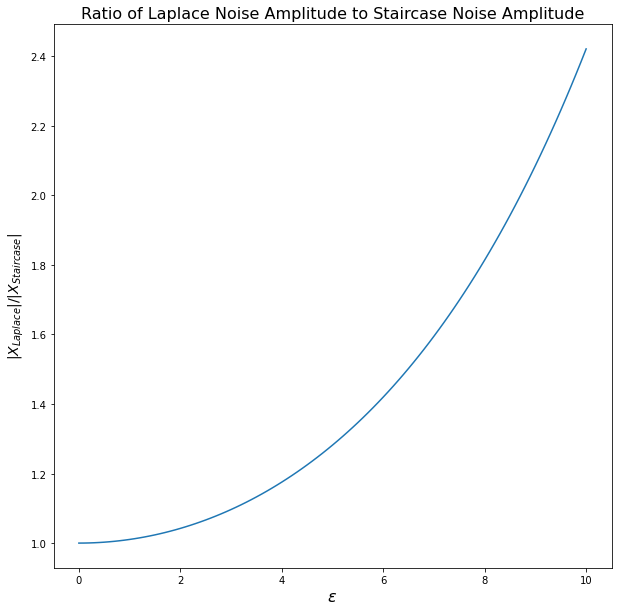

In [147]:
plot_lapl_staircase_ratio(1)